In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append('/projects/trans_scratch/validations/workspace/szong/Cervical/notebook')
from lineticks import LineTicks
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec
from adjustText import adjust_text
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### new plot 20190329

In [9]:
def get_data(df):
    '''get coordinates for points and point labels'''
    x = df['hiv-q(-log10)']
    y = df['hiv+q(-log10)']
    maxq = int(max(max(x), max(y))) + 2
    # points on y axis
    dfy = df[x==0][['cytoband','hiv-q(-log10)', 'hiv+q(-log10)']].sort_values('hiv+q(-log10)', ascending=False)
    pyxs = dfy['hiv-q(-log10)']
    pyys = dfy['hiv+q(-log10)']
    ybands = dfy['cytoband']#.tolist()
    # point on x axis
    dfx = df[y==0][['cytoband','hiv-q(-log10)', 'hiv+q(-log10)']].sort_values('hiv-q(-log10)', ascending=True)
    pxxs = dfx['hiv-q(-log10)']
    pxys = dfx['hiv+q(-log10)']
    xbands = dfx['cytoband']#.tolist()
    # points shared by 2 groups
    dfs = df[(x!=0)&(y!=0)][['cytoband','hiv-q(-log10)', 'hiv+q(-log10)']]
    psxs = dfs['hiv-q(-log10)']
    psys = dfs['hiv+q(-log10)']
    sbands = dfs['cytoband']#.tolist()
    return (x, y, maxq, 
            pyxs, pyys, ybands,
            pxxs, pxys, xbands,
            psxs, psys, sbands)
    

In [225]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 0))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    if 'top' in spines:
        ax.xaxis.set_ticks_position('top')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [248]:
def foo(**label_coords):
    if label_coords:
        print('xx')
    for a in label_coords:
        print(a, label_coords[a])
foo(lx=[33, 4], ly=[3, 5], lb=[1,2])

xx
lx [33, 4]
ly [3, 5]
lb [1, 2]


In [260]:
def label_sbands(xs, ys, ls, ax, legend, leg_title, **lb_coords):
    n = len(ls)
    ax.scatter(xs, ys, marker='+', s=26, c='black', alpha=1, label='in both')
    # label points
    texts = []
    lxs, lys, lbs = xs, ys, ls
    if lb_coords:
        print('xxxx')
        lxs, lys, lbs = lb_coords['lx'], lb_coords['ly'], lb_coords['lb']
        
    for x, y, l in zip(lxs, lys, lbs):
        _ = ax.text(x+0.25, y, l, rotation=0,# withdash=True, 
                    horizontalalignment='left', 
                    verticalalignment='center', fontsize=8)
        texts.append([x+0.25, y, l])
#     adjust_text(texts)
    if legend:
        ax.legend(title=leg_title, loc='upper left')
    dft = pd.DataFrame(texts)
    dft.columns = ['x', 'y', 'label']
    return dft

In [218]:
def label_xbands(xs, ys, ls, ax, xgroup, legend):
    n = len(ls)
    ax.scatter(xs, ys, marker='+', s=26, c='blue', alpha=1, label=f'{xgroup} only')
    # make up label coordinates
    lxs = np.linspace(-0.1, n*.6, n)
    lys = np.array(n*[-0.8])
    # label and connecting points
    for lx, ly, l, px, py in zip(lxs, lys, ls, xs, ys):
        _ = ax.plot((px, lx+.2), (py-0.2, ly+0.1), linestyle='dashed', 
                    color='gray',linewidth=.6)
        _ = ax.text(lx, ly, l, rotation=-90, withdash=True, 
                    horizontalalignment='left', 
                    verticalalignment='top', fontsize=7)
    if legend:
        ax.legend(loc='upper left')

In [217]:
def label_ybands(xs, ys, ls, ax, ygroup, legend):
    n = len(ls)
    ax.scatter(xs, ys, marker='+', s=26, c='red', alpha=1, label=f'{ygroup} only')
    # make up label coordinates
    lxs = np.array(n * [-0.8])
    lys = np.linspace(n*.6, -2, n)

    # label points
    for lx, ly, l, px, py in zip(lxs, lys, ls, xs, ys):
        _ = ax.plot((px-0.3, lx+0.1), (py, ly), linestyle='dashed', 
            color='gray', linewidth=.6)
        _ = ax.text(lx, ly, l, rotation=0, withdash=True, 
                    horizontalalignment='right', 
                    verticalalignment='center', fontsize=7)
    if legend:
        ax.legend(loc='upper left')

In [228]:
def remove_tickline_ticklables(ax):
    _ = plt.setp(ax.get_xticklines(),visible=False)
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_xticklabels(),visible=False)
    _ = plt.setp(ax.get_yticklabels(),visible=False)

### plot all 4 comparisons

In [108]:
cnvdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/'
of = f'{cnvdir}amps_cytoband_qvalue_comparison_hiv_pos_vs_neg.csv'
htmcp_amps = pd.read_csv(of)
htmcp_amps.head(2)
of = f'{cnvdir}dels_cytoband_qvalue_comparison_hiv_pos_vs_neg.csv'
htmcp_dels = pd.read_csv(of)
htmcp_dels.head(2)

of = f'{cnvdir}amps_cytoband_qvalue_comparison_tcga_vs_neg.csv'
tcga_amps = pd.read_csv(of)

of = f'{cnvdir}dels_cytoband_qvalue_comparison_tcga_vs_neg.csv'
tcga_dels = pd.read_csv(of)

,cytoband,q_value_hiv+,oncogenes_hiv+,num_genes_hiv+,q_value_hiv-,oncogenes_hiv-,num_genes_hiv-,hiv+q(-log10),hiv-q(-log10)
0,11q22.2,6.734800e-09,"BIRC3,YAP1",7.0,1.000000,NaN,NaN,8.171675,-0.000000
1,8q24.21,7.315600e-04,NaN,0.0,0.011296,"NDRG1,RAD21,EXT1,MYC",104.0,3.135750,1.947075


,cytoband,q_value_hiv+,oncogenes_hiv+,num_genes_hiv+,q_value_hiv-,oncogenes_hiv-,num_genes_hiv-,hiv+q(-log10),hiv-q(-log10)
0,2q22.1,9.596400e-16,LRP1B,1.0,0.003105,LRP1B,3.0,15.017892,2.507938
1,19p13.3,1.422000e-10,STK11,3.0,0.000007,STK11,3.0,9.847100,5.148033


In [212]:
def setup_ax(ax, xlim, ylim, xmtick_range, ymtick_range,xlabel, ylabel):
    _ = ax.set_xlim(xlim)
    _ = ax.set_ylim(ylim)
    ax.spines['right'].set_visible(False) # turn off right spine
    ax.spines['top'].set_visible(False)
    _ = ax.set_xticks(xmtick_range)
    _ = ax.set_yticks(ymtick_range)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('auto')


plot amp tcga vs hiv-
xxxx


,x,y,label
0,3.741686,24.857110,11q22.1
1,2.447075,7.616472,8q24.21
2,4.912289,11.541997,3q28
3,2.341668,2.500000,1q21.3
4,1.570275,0.800000,15q26.1


xxxx


,x,y,label
0,4.125197,24.773890,2q37.1
1,3.639932,14.685164,11q25
2,3.007938,16.123863,2q22.1
3,5.648033,10.108608,19p13.3
4,1.609138,3.800000,17q25.3
5,4.250000,2.990039,3p14.2
6,1.673945,2.300000,14q32.31
7,1.850000,1.500000,21q11.2
8,3.007938,0.700144,1p13.2


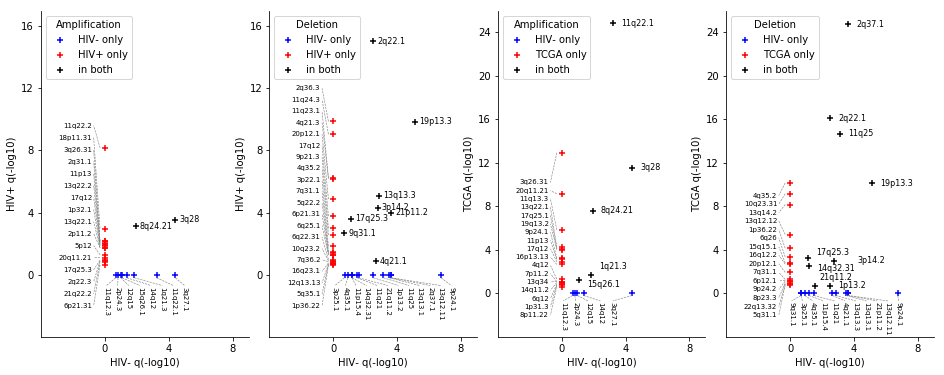

In [269]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(1, 4, hspace=0.3, wspace=0.1, 
                    width_ratios=[1,1,1,1], 
                    height_ratios=[1])

ax0 = plt.subplot(grid[0])

x, y, maxq, pyxs, pyys, ybands, pxxs, pxys, xbands, psxs, psys, sbands = get_data(htmcp_amps)
# # pot amp hiv+ vs -
xlim = (-4, 9)
ylim = (-4, 17)
xmtick_range = np.arange(0, 9, 4)
ymtick_range = np.arange(0, 17, 4)
xlabel = 'HIV- q(-log10)'
ylabel = 'HIV+ q(-log10)'
setup_ax(ax0, xlim, ylim, xmtick_range, ymtick_range, xlabel, ylabel)

_ = label_xbands(pxxs, pxys, xbands, ax0,'HIV-',  'legend')
_ = label_ybands(pyxs, pyys, ybands, ax0,'HIV+', 'legend')
_ = label_sbands(psxs, psys, sbands, ax0, 'legend', 'Amplification')



# # pot del hiv+ vs -
ax1 = plt.subplot(grid[1])
x, y, maxq, pyxs, pyys, ybands, pxxs, pxys, xbands, psxs, psys, sbands = get_data(htmcp_dels)
setup_ax(ax1, xlim, ylim, xmtick_range, ymtick_range, xlabel, ylabel)
_ = label_xbands(pxxs, pxys, xbands, ax1,'HIV-', 'legend')
_ = label_ybands(pyxs, pyys, ybands, ax1,'HIV+', 'legend')
_ = label_sbands(psxs, psys, sbands, ax1, 'legend', 'Deletion')

# pot amp tcga vs hiv-
ylabel = 'TCGA q(-log10)'
xlim = (-4, 9)
ylim = (-4, 26)
xmtick_range = np.arange(0, 9, 4)
ymtick_range = np.arange(0, 26, 4)

print('plot amp tcga vs hiv-')
ax2 = plt.subplot(grid[2])
x, y, maxq, pyxs, pyys, ybands, pxxs, pxys, xbands, psxs, psys, sbands = get_data(tcga_amps)
setup_ax(ax2, xlim, ylim, xmtick_range, ymtick_range, xlabel, ylabel)
_ = label_xbands(pxxs, pxys, xbands, ax2,'HIV-', 'legend')
_ = label_ybands(pyxs, pyys, ybands, ax2,'TCGA', 'legend')
# dft = label_sbands(psxs, psys, sbands, ax2, 'legend', 'Amplification')
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/tcga_amps_shared_labels.txt'
# dft.to_csv(of, sep='\t', index=False)
dft = pd.read_csv(of, sep='\t')
lxss, lyss, lbss = dft['x'], dft['y'], dft['label']
label_sbands(psxs, psys, sbands, ax2, 'legend', 'Amplification', lx=lxss, ly=lyss, lb=lbss)

ax3 = plt.subplot(grid[3])
x, y, maxq, pyxs, pyys, ybands, pxxs, pxys, xbands, psxs, psys, sbands = get_data(tcga_dels)
setup_ax(ax3, xlim, ylim, xmtick_range, ymtick_range, xlabel, ylabel)
_ = label_xbands(pxxs, pxys, xbands, ax3,'HIV-', 'legend')
_ = label_ybands(pyxs, pyys, ybands, ax3,'TCGA','legend')
# dft = label_sbands(psxs, psys, sbands, ax3, 'legend', 'Deletion')
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/tcga_shared_labels.txt'
# dft.to_csv(of, sep='\t', index=False)
# read in manually curated label coordinates
dft = pd.read_csv(of, sep='\t')
lxss, lyss, lbss = dft['x'], dft['y'], dft['label']
label_sbands(psxs, psys, sbands, ax3, 'legend', 'Deletion',lx=lxss, ly=lyss, lb=lbss )
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/significantly_altered_cytobands_comparison.png'
# plt.savefig(of, bbox_inches='tight', dpi=300)
pdf = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/significantly_altered_cytobands_comparison_20190402.pdf'
plt.savefig(pdf,bbox_inches='tight',dpi=300)

In [232]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/tcga_shared_labels.txt'
dft = pd.read_csv(of, sep='\t')
psxs, psys, sbands = dft['x'], dft['y'], dft['label'] 

In [231]:
dft

,x,y,label
0,3.875197,24.773890,2q37.1
1,3.389932,14.685164,11q25
2,2.757938,16.123863,2q22.1
3,5.398033,10.108608,19p13.3
4,1.359138,3.500000,17q25.3
5,4.000000,2.990039,3p14.2
6,1.423945,2.300000,14q32.31
7,1.843017,2.000000,21q11.2
8,2.757938,0.700144,1p13.2


In [324]:
tcga_amps[tcga_amps['hiv+q(-log10)']==0]

,cytoband,q_value_hiv+,oncogenes_hiv+,num_genes_hiv+,q_value_hiv-,oncogenes_hiv-,num_genes_hiv-,hiv+q(-log10),hiv-q(-log10)
13,1q21.3,1.0,NaN,NaN,0.008915,"PLEKHO1,BCL9,RAB25,AIM2,NOTCH2,NTRK1,PDE4DIP,M...",396.0,-0.0,2.049879
14,8q24.22,1.0,NaN,NaN,0.041088,"KLF10,MTSS1,EXT1,FBXO32,SCRIB,NDRG1,MAFA,MYC,C...",278.0,-0.0,1.386285
15,15q26.1,1.0,NaN,NaN,0.051705,"NTRK3,BLM,CRTC3,FES,IDH2",69.0,-0.0,1.286467
16,2p24.3,1.0,NaN,NaN,0.117580,"NCOA1,MYCN,ALK,SOX11,RHOB,C2orf44,DNMT3A",206.0,-0.0,0.929667
17,19q13.43,1.0,NaN,NaN,0.136820,"GLTSCR1,ZNF331,KLK2,CIC,MIRLET7E,TGFB1,ERCC2,A...",777.0,-0.0,0.863850


In [247]:
len(x)
len(y)

1000

36

[[<matplotlib.lines.Line2D at 0x7f6981ff53c8>],

[[<matplotlib.lines.Line2D at 0x7f6981f84780>],

Text(0.5,0,'time')

Text(0,0.5,'value')

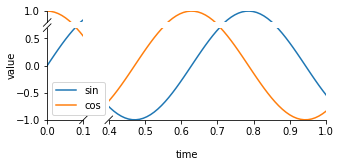

In [236]:



fig = plt.figure(figsize=(5,2))
bax = brokenaxes(xlims=((0, .1), (.4, 1)), ylims=((-1, .7), (.79, 1)), hspace=.1)
x = np.linspace(0, 1, 100)
bax.plot(x, np.sin(10 * x), label='sin')
bax.plot(x, np.cos(10 * x), label='cos')
bax.legend(loc=3)
bax.set_xlabel('time')
bax.set_ylabel('value')

[[<matplotlib.lines.Line2D at 0x7f69818f2c88>],

[(array([195., 234., 227., 260.,  47.,  24.,  12.,   0.,   0.,   1.]),
  array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
  <a list of 10 Patch objects>),
 (array([195., 234., 227., 260.,  47.,  24.,  12.,   0.,   0.,   1.]),
  array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
  <a list of 10 Patch objects>)]

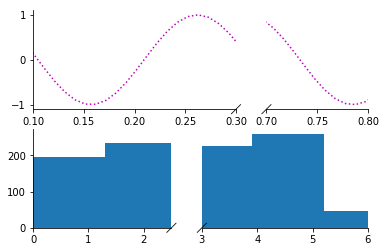

In [241]:
sps1, sps2 = GridSpec(2,1)

bax = brokenaxes(xlims=((.1, .3),(.7, .8)), subplot_spec=sps1,  hspace=.02)
x = np.linspace(0, 1, 100)
bax.plot(x, np.sin(x*30), ls=':', color='m')

x = np.random.poisson(3, 1000)
bax = brokenaxes(xlims=((0, 2.5), (3, 6)), subplot_spec=sps2, hspace=.01)
bax.hist(x, histtype='bar')

In [131]:
dftmp = pd.merge(hposold, hpos, left_on='cytoband', right_on='cytoband', how='outer').fillna(1)
dftmp.head(2)

,cytoband,q_value_x,q_value_y
0,11q22.1,3.544700e-09,1.000000
1,8q24.21,1.045400e-04,0.000732


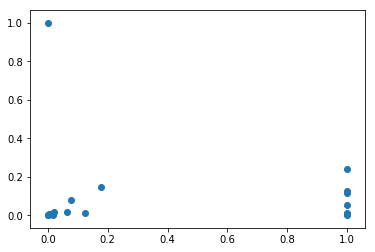

In [132]:
plt.scatter(dftmp['q_value_x'], dftmp['q_value_y'])